# Package Preparation

In [2]:
%pip install transformers
%pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=32217dec47ff2263f1f68e95bd16c1b43cb9db2279162f9c968e53b22de89940
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import shutil
from timeit import default_timer
import random
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
import tensorflow as tf

# Drive Mount

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Change to your specific path.
%cd "/content/drive/MyDrive/Workspace/tagrec"

/content/drive/MyDrive/Workspace/tagrec


# Helper Functions (Recall & Precision)

In [6]:
def recall_at_k(topk_indices, test_indices, verbose=False):  # topk_indices shape: m x k, test_indices: list len m.   
    # k is implicitly the 2nd dimension of topk_indices
    correctly_pred = 0
    num_instances = len(test_indices)
    for i in range(num_instances):
      if test_indices[i] in topk_indices[i]:
        correctly_pred += 1
    if verbose:
      print('correctly pred: ', correctly_pred, ', total # of data instances: ', num_instances)
    return correctly_pred, correctly_pred / num_instances

In [7]:
def precision_at_k(topk_indices, test_indices, verbose=False):  # topk_indices shape: m x k, test_indices: list len m.   
    # k is implicitly the 2nd dimension of topk_indices
    correctly_pred, _ = recall_at_k(topk_indices, test_indices)
    num_preds = len(test_indices) * topk_indices.shape[1]
    if verbose:
      print('correctly pred:', correctly_pred, ', total # of preds: ', num_preds)
    return correctly_pred / num_preds

# Model Definition

## Super Class

In [8]:
class TagRecModel:
    def __init__(self, train_set_path=None, val_set_path=None, test_set_path=None, test_data_path=None, label_col_name=None):
        # training set
        if train_set_path is not None:
            self.train_set = torch.load(train_set_path)
        else: 
            self.train_set = None
        
        # validation set
        if val_set_path is not None:
            self.val_set = torch.load(val_set_path)
        else: 
            self.val_set = None
        
        # testing set
        if test_set_path is not None:
            self.test_set = torch.load(test_set_path)
        else:
            self.test_set = None
        
        self.LE = LabelEncoder()  # label encoder that encodes labels to value between 0 and n_classes-1
        self.test_unique_labels = None  # all unique labels
        if test_data_path is not None and label_col_name is not None:
            test_data = pd.read_csv(test_data_path)
            test_labels = test_data[label_col_name]
            self.test_unique_labels = test_labels.unique()
            self.LE.fit_transform(self.test_unique_labels)
        
        self.training_stats = []
        
        # Use GPU if possible
        if torch.cuda.is_available():      
            self.device = torch.device("cuda")
            print('There are %d GPU(s) available.' % torch.cuda.device_count())
            print('Using GPU:', torch.cuda.get_device_name(0))
        else:
            self.device = torch.device("cpu")
            print('No GPU available, using the CPU instead.')
    
    # ------------------------------- Data Preprocessing -------------------------------
    
    def get_cleaned_taxonomy(self, taxonomy, delimiter):
        cleaned_taxonomy = []
        for value in taxonomy:
            value = ' '.join(value.lower().split(delimiter))
            cleaned_taxonomy.append( value )
        return cleaned_taxonomy
    
    def tokenize_and_format(self, input_data, tokenizer):
        input_ids = []
        attention_masks = []

        for text in input_data:
            encoded_dict = tokenizer.encode_plus(
                text,  # Sentence to encode.
                add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                max_length=128,  # Pad & truncate all sentences.
                padding='max_length',
                truncation=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='pt',  # Return pytorch tensors.
            )

            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return input_ids, attention_masks
    
    def tokenize_and_encode_mpnet(self, input_filename, feature_col_name, label_col_name,
                                  save_filename, train_val_test, tokenizer, label_encoder):
        # input_ids, attns_masks
        data = pd.read_csv(input_filename)
        features = data[feature_col_name]
        input_ids, attention_masks = self.tokenize_and_format(features, tokenizer)

        # encode labels
        labels = data[label_col_name]
        clean_labels = self.get_cleaned_taxonomy(labels, delimiter="_")
        taxonomy_vectors = label_encoder.encode(clean_labels)
        taxonomy_tensors = torch.Tensor(taxonomy_vectors)

        # encode unique labels
        unique_labels = labels.unique()
        clean_unique_labels = self.get_cleaned_taxonomy(unique_labels, delimiter="_")
        unique_taxonomy_vectors = label_encoder.encode(clean_unique_labels)
        unique_taxonomy_tensors = torch.Tensor(unique_taxonomy_vectors)

        # dataset is a tuple:
        # dataset[0] is list of input_ids, attention_masks, true label encoding
        # dataset[1] is all label tensors encoding
        if train_val_test == "train":
            dataset = [(input_ids[i], attention_masks[i], taxonomy_tensors[i]) for i in range(len(input_ids))], unique_taxonomy_tensors
            self.train_set = dataset
        elif train_val_test == "val":
            dataset = [(input_ids[i], attention_masks[i], taxonomy_tensors[i]) for i in range(len(input_ids))], unique_taxonomy_tensors
            self.val_set = dataset
        else:
            self.test_unique_labels = unique_labels
            self.LE.fit_transform(unique_labels)  # tell LabelEncoder this is the labels we want to enocde
            test_labels = self.LE.transform(labels)  # encode all labels
            test_labels = torch.Tensor(test_labels)
            dataset = [(input_ids[i], attention_masks[i], test_labels[i]) for i in range(len(input_ids))], unique_taxonomy_tensors
            self.test_set = dataset
        
        torch.save(dataset, save_filename)
        return dataset
    
    def process_data(self, train_filename, val_filename, test_filename,
                     feature_col_name, label_col_name,
                     train_save_filename, val_save_filename, test_save_filename,
                     tokenizer, label_encoder):
        self.train_set = self.tokenize_and_encode_mpnet(input_filename=train_filename,
                                                        feature_col_name=feature_col_name,
                                                        label_col_name=label_col_name,
                                                        save_filename=train_save_filename,
                                                        train_val_test="train",
                                                        tokenizer=tokenizer,
                                                        label_encoder=label_encoder)
        
        self.val_set = self.tokenize_and_encode_mpnet(input_filename=val_filename,
                                                      feature_col_name=feature_col_name,
                                                      label_col_name=label_col_name,
                                                      save_filename=val_save_filename,
                                                      train_val_test="val",
                                                      tokenizer=tokenizer,
                                                      label_encoder=label_encoder)

        self.test_set = self.tokenize_and_encode_mpnet(input_filename=test_filename,
                                                       feature_col_name=feature_col_name,
                                                       label_col_name=label_col_name,
                                                       save_filename=test_save_filename,
                                                       train_val_test="test",
                                                       tokenizer=tokenizer,
                                                       label_encoder=label_encoder)
    
    # ------------------------------- Training -------------------------------
    
    def train(self, model, criterion, optimizer, early_stopper,
              epochs, batch_size, random_seed, output_dir, model_name):
        """
        Parameters
        ----------
        model: PyTorch Model
            Input text encoder
        criterion: 
            loss function
        optimizer: 
            optimizer used to train the model
        early_stopper:
            early stopper, required to have a 'early_stop' method to check whether needs to early stops the training
        epochs: int
            number of training epochs
        batch_size: int
            batch size
        random_seed: int
            random seed
        output_dir: string
            output directory
        model_name: string
            name of the model
        
        Returns
        -------
        """
        # Create the output path directory.
        os.makedirs(output_dir, exist_ok=True)

        # Set random seeds.
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        random.seed(random_seed)
        
        # Tell pytorch to run this model on the GPU.
        model.cuda()
        
        summary_stats = []

        all_labels = self.train_set[1]
        all_labels = all_labels.to(self.device)

        train_set = self.train_set[0]

        for epoch_i in range(0, epochs):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            start_time = default_timer()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            num_batches = int(len(train_set)/batch_size) + 1

            for i in range(num_batches):
                if i % 40 == 0 and i > 0:
                    print('Batch {} of {}.'.format(i, num_batches))
                end_index = min(batch_size * (i+1), len(train_set))

                batch = train_set[i*batch_size:end_index]

                if len(batch) == 0: continue

                input_id_tensors = torch.stack([data[0] for data in batch])
                input_mask_tensors = torch.stack([data[1] for data in batch])
                label_tensors = torch.stack([data[2] for data in batch])

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(self.device)
                b_input_mask = input_mask_tensors.to(self.device)
                b_labels = label_tensors.to(self.device)

                # Clear the previously calculated gradient
                model.zero_grad()

                # Forward pass, calculate logit predictions.
                b_outputs = model(b_input_ids, b_input_mask)
                loss = criterion.forward(b_outputs, b_labels, all_labels)
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                optimizer.step()

            avg_train_loss = total_train_loss / len(train_set)
            end_time = default_timer()
            elapsed_time = end_time - start_time
            print('Average train loss: {}'.format(avg_train_loss))

            _, avg_val_loss = self.test(model, criterion, self.val_set, batch_size)
            print('Average validation loss: {}'.format(avg_val_loss))

            summary_stats.append({
                'Epoch': epoch_i + 1,
                'Average train loss': avg_train_loss,
                'Validation loss': avg_val_loss,
                'Training time': elapsed_time
            })

            if early_stopper.early_stop(model, avg_val_loss, epoch_i, output_dir, model_name):
                print("Early stopping at epoch {}".format(epoch_i + 1))
                break

        self.training_stats = summary_stats
    
    # function to get validation accuracy
    def test(self, model, criterion, test_set, batch_size):
        
        # Put the model in evaluation mode - no drop out during eval
        model.eval()

        all_labels = test_set[1]
        all_labels = all_labels.to(self.device)

        test_set = test_set[0]

        # Tracking variables 
        total_test_loss = 0
        all_outputs = torch.Tensor().to(self.device)

        num_batches = int(len(test_set)/batch_size) + 1


        for i in range(num_batches):

          end_index = min(batch_size * (i+1), len(test_set))

          batch = test_set[i*batch_size:end_index]

          if len(batch) == 0: continue

          input_id_tensors = torch.stack([data[0] for data in batch])
          input_mask_tensors = torch.stack([data[1] for data in batch])
          label_tensors = torch.stack([data[2] for data in batch])

          # Move tensors to the GPU
          b_input_ids = input_id_tensors.to(self.device)
          b_input_mask = input_mask_tensors.to(self.device)
          b_labels = label_tensors.to(self.device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            b_outputs = model(b_input_ids, b_input_mask)
            loss = criterion.forward(b_outputs, b_labels, all_labels)

            # Append current outputs to all outputs
            all_outputs = torch.cat((all_outputs, b_outputs), dim=0)

            # Accumulate the validation loss.
            total_test_loss += loss.item()

        # Calculate the average loss over all of the batches.
        avg_test_loss = total_test_loss / len(test_set)

        return all_outputs, avg_test_loss
    
    def plot_train_val_loss(self, figure_path):
      # transform to dataframe
      data = pd.DataFrame(data=self.training_stats)

      # plot
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(data['Average train loss'], '-o', label="Training Loss")
      plt.plot(data['Validation loss'], '-o', label="Validation Loss")

      plt.title("Training & Validation Loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.legend()
      plt.savefig(figure_path)
      plt.show()
        
    # ------------------------------- Evaluation -------------------------------

    def eval(self, model, criterion, k, random_seed):
        """
        Parameters
        ----------
        model:
            Input text encoder
        criterion:
            loss function
        k: 
            positive integer that will be used to calculate the precision/recall
        random_seed:
            random seed

        Returns
        -------
        """
        # set random seed
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        random.seed(random_seed)

        # Tell pytorch to run this model on the GPU.
        model.cuda()
        
        # Put the model in evaluation mode - no drop out during eval
        model.eval()
        
        all_labels = self.test_set[1]  # all encoded unique labels 
        all_labels = all_labels.to(self.device)
        test_set = self.test_set[0]  # (input_id, attention_mask, true_label) tuple

        cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
        y_true = []
        y_pred = []  # record predictions of the model
        
        for input_id, attention_mask, true_label in test_set:
            input_id = input_id.to(self.device)
            attention_mask = attention_mask.to(self.device)
            
            with torch.no_grad():
                outputs = model(input_id.reshape(1,-1), attention_mask.reshape(1,-1))
            
            # Find k most similar labels
            distances = cos_sim(outputs[:,None], all_labels)  
            distances, indices = torch.topk(distances, k, largest=True) 
            # use indices to find correspodning labels, and encode them to value between 0 and n_classes-1
            y_pred.append(self.LE.transform(self.test_unique_labels[indices.cpu().numpy().flatten()]))
            y_true.append(int(true_label))

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        recall_hit, recall_score = recall_at_k(y_pred, y_true)
        print(f'For k = {k}, we have recall@k: {recall_score}')

        return recall_hit, recall_score

## Model (Input Encoder)

In [9]:
# Model for creating input embedding
class InputEncoder(nn.Module):
    def __init__(self, pretrained_model="bert-base-uncased", output_dim=1024):
        """
        Parameters
        ----------
        pretrained_model: String
            the model id of a pretrained model hosted inside a model repo on huggingface
            the list of available pretrained models can be seen here: 
            https://huggingface.co/transformers/v3.3.1/pretrained_models.html
            Note that the dim of the last hidden state is 768 in the paper, so the pretrained model should be a 'base' model

        Returns
        -------
        """
        super(InputEncoder, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)  # load pretrained bert
        self.dropout = nn.Dropout(0.1)  # use p=0.1 to align with the dropout rate in pretrained bert 
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, output_dim)
    
    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]  # we need pooler_output instead of last_hidden_state
        x = self.dropout(x)
        x = self.dropout(self.linear1(x))
        x = self.linear2(x)
        return x

## Universal Sentence Encoder

In [10]:
class USEEmbedding(): 
    def __init__(self, module_url="https://tfhub.dev/google/universal-sentence-encoder-large/5"):
        self.model = hub.load(module_url)
    
    def encode(self, input):
      output = self.model(input)
      return torch.tensor(output.numpy())  # convert to torch tensor

## Loss Function

In [11]:
# Our Loss Function
class HingeRankLoss(nn.Module):
    def __init__(self, margin):
        super(HingeRankLoss, self).__init__()
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        self.margin = margin

    def forward(self, output, corr_labels, all_labels):
        loss = torch.relu(
            self.margin
            - self.cos_sim(output[:,None], corr_labels[:,None])
            + self.cos_sim(output[:,None], all_labels)
        )  # torch.Size([32, num_unique_labels])
        loss = torch.sum(loss)  # scalar tensor

        dup_loss = max(self.margin, 0.) * len(output)
        dup_loss = torch.tensor(dup_loss, dtype=torch.float32)
        total_loss = loss - dup_loss

        counts = len(output) * (len(all_labels) - 1)
        return total_loss / counts

## Early Stopper

In [12]:
def save_checkpoint(state_dict, is_best, epoch, output_dir, model_name):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    checkpoints_dir = './checkpoints'
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    checkpoint_file = os.path.join(checkpoints_dir, f'{model_name}_checkpoint_{epoch}.pth.tar')
    torch.save(state_dict, checkpoint_file)
    if is_best:
        shutil.copyfile(checkpoint_file, os.path.join(output_dir, f'{model_name}_best.pth.tar'))


class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.counter = 0
        self.min_delta = min_delta
        self.min_val_loss = np.inf

    def early_stop(self, model, val_loss, epoch, output_dir, model_name):
        if val_loss < self.min_val_loss + self.min_delta:
            print(f'=> Model at epoch {epoch + 1} is the best according to validation loss')
            save_checkpoint(state_dict=model.state_dict(), is_best=True, epoch=epoch, output_dir=output_dir, model_name=model_name)
            self.min_val_loss = val_loss
            self.counter = 0
        else:
            save_checkpoint(state_dict=model.state_dict(), is_best=False, epoch=epoch, output_dir=output_dir, model_name=model_name)
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Non-hierarchical ARC Data Transformation

In [13]:
def transform_non_hierarchical_arc(csv_filepath, output_filepath):
    pretransformed_data = pd.read_csv(csv_filepath)
    pretransformed_data.rename(columns={'Question': 'question', 'QCLabel': 'label'}, inplace=True)
    pretransformed_data = pretransformed_data[['question', 'label']]
    pretransformed_data['label'] = [i.split('_')[-1] for i in pretransformed_data['label']]
    pretransformed_data.to_csv(output_filepath, index=False)
    print(f'Finish transforming {csv_filepath} -> {output_filepath}')

In [15]:
transform_non_hierarchical_arc('data/ARC_data_train.csv', 'data/NonHierarchical_ARC_raw_train.csv')
transform_non_hierarchical_arc('data/ARC_data_val.csv', 'data/NonHierarchical_ARC_raw_val.csv')
transform_non_hierarchical_arc('data/ARC_data_test.csv', 'data/NonHierarchical_ARC_raw_test.csv')

Finish transforming data/ARC_data_train.csv -> data/NonHierarchical_ARC_raw_train.csv
Finish transforming data/ARC_data_val.csv -> data/NonHierarchical_ARC_raw_val.csv
Finish transforming data/ARC_data_test.csv -> data/NonHierarchical_ARC_raw_test.csv


# For Sentence BERT

## Data Preprocessing

You can skip this part if you already construct datasets.

In [16]:
label_encoder = SentenceTransformer('bert-large-nli-stsb-mean-tokens')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [17]:
tagrec_model = TagRecModel()
tagrec_model.process_data(train_filename="data/NonHierarchical_ARC_raw_train.csv",
                          val_filename="data/NonHierarchical_ARC_raw_val.csv",
                          test_filename="data/NonHierarchical_ARC_raw_test.csv",
                          feature_col_name="question",
                          label_col_name="label",
                          train_save_filename="data/NonHierarchical_ARC_sent_bert_train.pt",
                          val_save_filename="data/NonHierarchical_ARC_sent_bert_val.pt",
                          test_save_filename="data/NonHierarchical_ARC_sent_bert_test.pt",
                          tokenizer=tokenizer,
                          label_encoder=label_encoder)

There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


## Create TagRecModel instance

In [18]:
random_seed = 48

In [19]:
model_name = 'NHARC_BERT_SENT_BERT'

In [20]:
tagrec_model = TagRecModel(train_set_path="data/NonHierarchical_ARC_sent_bert_train.pt",
                           val_set_path="data/NonHierarchical_ARC_sent_bert_val.pt",
                           test_set_path="data/NonHierarchical_ARC_sent_bert_test.pt",
                           test_data_path="data/NonHierarchical_ARC_raw_test.csv",
                           label_col_name="label")

criterion = HingeRankLoss(0.1)

There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


## Training

In [21]:
model = InputEncoder("bert-base-uncased")
early_stopper = EarlyStopper(patience=5, min_delta=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
epochs = 30
batch_size = 32

In [23]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 2e-5,
                              eps = 1e-8)

tagrec_model.train(model=model,
                   criterion=criterion,
                   optimizer=optimizer,
                   early_stopper=early_stopper,
                   epochs=epochs,
                   batch_size=batch_size,
                   random_seed=random_seed,
                   output_dir="./models",
                   model_name=model_name)


======== Epoch 1 / 30 ========
Batch 40 of 175.
Batch 80 of 175.
Batch 120 of 175.
Batch 160 of 175.
Average train loss: 0.0021460595460332716
Average validation loss: 0.0012069477275933275
=> Model at epoch 1 is the best according to validation loss

======== Epoch 2 / 30 ========
Batch 40 of 175.
Batch 80 of 175.
Batch 120 of 175.
Batch 160 of 175.
Average train loss: 0.0008922883818431562
Average validation loss: 0.0006768960783444823
=> Model at epoch 2 is the best according to validation loss

======== Epoch 3 / 30 ========
Batch 40 of 175.
Batch 80 of 175.
Batch 120 of 175.
Batch 160 of 175.
Average train loss: 0.0005245396870056795
Average validation loss: 0.0005084525525646528
=> Model at epoch 3 is the best according to validation loss

======== Epoch 4 / 30 ========
Batch 40 of 175.
Batch 80 of 175.
Batch 120 of 175.
Batch 160 of 175.
Average train loss: 0.00034245403070180504
Average validation loss: 0.00041204000341976514
=> Model at epoch 4 is the best according to valida

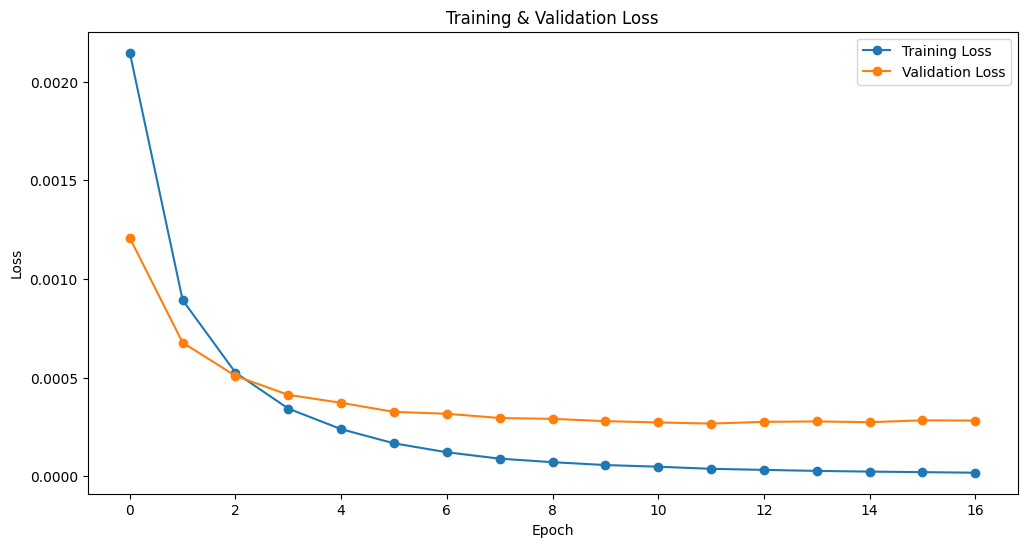

In [24]:
os.makedirs('./figures', exist_ok=True)
tagrec_model.plot_train_val_loss(figure_path=f"./figures/{model_name}_train_val_loss.png")

## Evaluation

In [25]:
eval_model = InputEncoder("bert-base-uncased")
eval_model.load_state_dict(torch.load(f'models/{model_name}_best.pth.tar'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [26]:
_, score_5 = tagrec_model.eval(model=eval_model,
                                criterion=criterion,
                                k=5,
                                random_seed=random_seed)

_, score_10 = tagrec_model.eval(model=eval_model,
                                criterion=criterion,
                                k=10,
                                random_seed=random_seed)

_, score_15 = tagrec_model.eval(model=eval_model,
                                criterion=criterion,
                                k=15,
                                random_seed=random_seed)

_, score_20 = tagrec_model.eval(model=eval_model,
                                criterion=criterion,
                                k=20,
                                random_seed=random_seed)

For k = 5, we have recall@k: 0.7021428571428572
For k = 10, we have recall@k: 0.7814285714285715
For k = 15, we have recall@k: 0.8185714285714286
For k = 20, we have recall@k: 0.8485714285714285


# For USE

## Data Preprocessing

You can skip this part if you already construct datasets.

In [27]:
label_encoder = USEEmbedding("https://tfhub.dev/google/universal-sentence-encoder-large/5")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [28]:
tagrec_model = TagRecModel()
tagrec_model.process_data(train_filename="data/NonHierarchical_ARC_raw_train.csv",
                          val_filename="data/NonHierarchical_ARC_raw_val.csv",
                          test_filename="data/NonHierarchical_ARC_raw_test.csv",
                          feature_col_name="question",
                          label_col_name="label",
                          train_save_filename="data/NonHierarchical_ARC_use_train.pt",
                          val_save_filename="data/NonHierarchical_ARC_use_val.pt",
                          test_save_filename="data/NonHierarchical_ARC_use_test.pt",
                          tokenizer=tokenizer,
                          label_encoder=label_encoder)

There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


## Create TagRecModel instance

In [29]:
random_seed = 48

In [30]:
model_name = 'NHARC_USE'

In [31]:
tagrec_model = TagRecModel(train_set_path="data/NonHierarchical_ARC_use_train.pt",
                           val_set_path="data/NonHierarchical_ARC_use_val.pt",
                           test_set_path="data/NonHierarchical_ARC_use_test.pt",
                           test_data_path="data/NonHierarchical_ARC_raw_test.csv",
                           label_col_name="label")

criterion = HingeRankLoss(0.1)

There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


## Training

In [32]:
model = InputEncoder("bert-base-uncased", output_dim=512)
early_stopper = EarlyStopper(patience=5, min_delta=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
epochs = 30
batch_size = 32

In [34]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 2e-5,
                              eps = 1e-8)

tagrec_model.train(model=model,
                   criterion=criterion,
                   optimizer=optimizer,
                   early_stopper=early_stopper,
                   epochs=epochs,
                   batch_size=batch_size,
                   random_seed=random_seed,
                   output_dir="./models",
                   model_name=model_name)


======== Epoch 1 / 30 ========
Batch 40 of 175.
Batch 80 of 175.
Batch 120 of 175.
Batch 160 of 175.
Average train loss: 0.0018392809777679838
Average validation loss: 0.0009670707619818439
=> Model at epoch 1 is the best according to validation loss

======== Epoch 2 / 30 ========
Batch 40 of 175.
Batch 80 of 175.
Batch 120 of 175.
Batch 160 of 175.
Average train loss: 0.0006801732413953961
Average validation loss: 0.0005664532779115025
=> Model at epoch 2 is the best according to validation loss

======== Epoch 3 / 30 ========
Batch 40 of 175.
Batch 80 of 175.
Batch 120 of 175.
Batch 160 of 175.
Average train loss: 0.00038097387691235913
Average validation loss: 0.00039930814448600407
=> Model at epoch 3 is the best according to validation loss

======== Epoch 4 / 30 ========
Batch 40 of 175.
Batch 80 of 175.
Batch 120 of 175.
Batch 160 of 175.
Average train loss: 0.00023418326252478723
Average validation loss: 0.00034400185325917976
=> Model at epoch 4 is the best according to vali

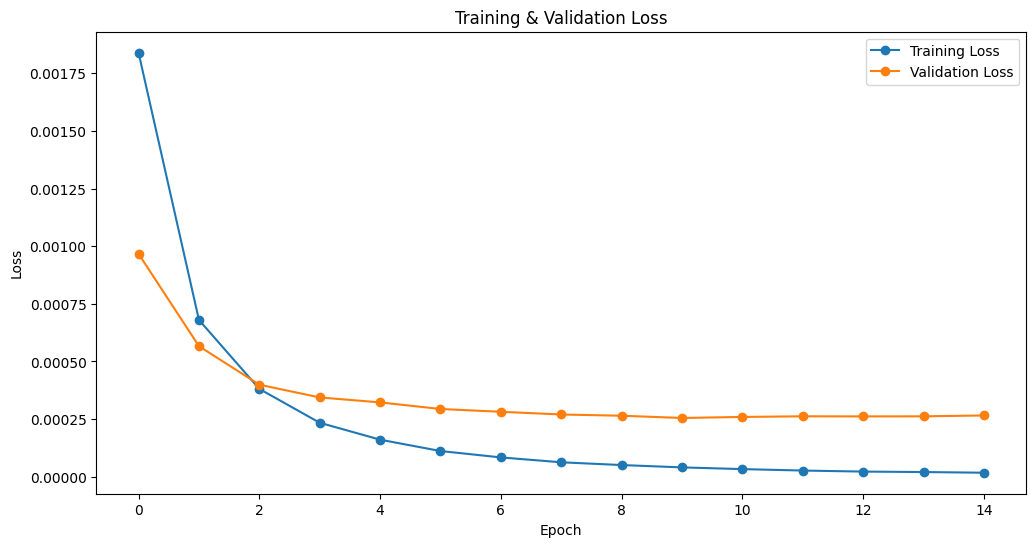

In [35]:
os.makedirs('./figures', exist_ok=True)
tagrec_model.plot_train_val_loss(figure_path=f"./figures/{model_name}_train_val_loss.png")

## Evaluation

In [36]:
eval_model = InputEncoder("bert-base-uncased", output_dim=512)
eval_model.load_state_dict(torch.load(f'models/{model_name}_best.pth.tar'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [37]:
_, score_5 = tagrec_model.eval(model=eval_model,
                                criterion=criterion,
                                k=5,
                                random_seed=random_seed)

_, score_10 = tagrec_model.eval(model=eval_model,
                                criterion=criterion,
                                k=10,
                                random_seed=random_seed)

_, score_15 = tagrec_model.eval(model=eval_model,
                                criterion=criterion,
                                k=15,
                                random_seed=random_seed)

_, score_20 = tagrec_model.eval(model=eval_model,
                                criterion=criterion,
                                k=20,
                                random_seed=random_seed)

For k = 5, we have recall@k: 0.7521428571428571
For k = 10, we have recall@k: 0.8328571428571429
For k = 15, we have recall@k: 0.8742857142857143
For k = 20, we have recall@k: 0.8914285714285715


# Monte Carlo (Deprecated)

We were planning to do the K-fold Cross-Validation or Monte Carlo Cross-Validation, but ended up finding out that recall scores are not varying a lot. So we ended up do not use any cross-validation methodology. This section is deprecated and is not intended to run.

In [1]:
random_seed = 48

epochs = 30
batch_size = 32

model_name = 'NON_HIERARCHICAL_ARC_K_FOLD'

k_fold = 5
val_ratio = 0.1
test_ratio = 0.2

In [ ]:
source_path = ['data/train_QC_data.csv', 'data/val_QC_data.csv', 'data/test_QC_data.csv']
merged_file_path = f'data/{model_name}_merged.csv'

## Monte Carlo Merged Data Preparation

In [ ]:
merged_df = pd.DataFrame()
for csv in source_path:
    df = pd.read_csv(csv)
    merged_df = pd.concat([merged_df, df])
merged_df.to_csv(merged_file_path, index=False)

In [ ]:
# This code is specifically for non-hierarchical ARC dataset.
transform_non_hierarchical_arc(merged_file_path, merged_file_path)

Finish transforming data/NON_HIERARCHICAL_ARC_K_FOLD_merged.csv -> data/NON_HIERARCHICAL_ARC_K_FOLD_merged.csv


## Monte Carlo Split Generation

In [ ]:
import uuid

def extension_remover(file_path):
    return '.'.join(file_path.split('.')[:-1])

def k_fold_split():
    df = pd.read_csv(merged_file_path)
    
    if not os.path.exists('data/splits'):
        os.makedirs('data/splits')
    
    file_paths = []

    val_size = int(len(df) * val_ratio)
    test_size = int(len(df) * test_ratio)
    train_size = len(df) - val_size - test_size

    for fold in range(k_fold):
        curr_rand_state = np.random.randint(0, high=1000, size=1).item()
        sampled_df = df.sample(frac=1, random_state=curr_rand_state).reset_index(drop=True)

        val_start = train_size % len(df)
        test_start = (val_start + val_size) % len(df)

        val_indices = list(range(val_start, val_start + val_size))
        test_indices = list(range(test_start, test_start + test_size))
        train_indices = list(set(range(len(df))) - set(val_indices) - set(test_indices))

        train_df = sampled_df.loc[train_indices].copy(deep=True)
        val_df = sampled_df.loc[val_indices].copy(deep=True)
        test_df = sampled_df.loc[test_indices].copy(deep=True)

        fold_id = str(uuid.uuid4())

        train_file_name = f'data/splits/{model_name}_fold_{fold_id}_train.csv'
        val_file_name = f'data/splits/{model_name}_fold_{fold_id}_val.csv'
        test_file_name = f'data/splits/{model_name}_fold_{fold_id}_test.csv'
        
        train_df.to_csv(train_file_name, index=False)
        val_df.to_csv(val_file_name, index=False)
        test_df.to_csv(test_file_name, index=False)
        
        file_paths.append((train_file_name, val_file_name, test_file_name, fold_id))

    return file_paths

file_paths = k_fold_split()
file_paths

[('data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_d158bb14-6fc1-4fbf-bb25-dbb2422ba6fb_train.csv',
  'data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_d158bb14-6fc1-4fbf-bb25-dbb2422ba6fb_val.csv',
  'data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_d158bb14-6fc1-4fbf-bb25-dbb2422ba6fb_test.csv',
  'd158bb14-6fc1-4fbf-bb25-dbb2422ba6fb'),
 ('data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_f680da24-08c5-4067-9dd4-d70f04486046_train.csv',
  'data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_f680da24-08c5-4067-9dd4-d70f04486046_val.csv',
  'data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_f680da24-08c5-4067-9dd4-d70f04486046_test.csv',
  'f680da24-08c5-4067-9dd4-d70f04486046'),
 ('data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_4d207716-1411-47f3-aa3d-dc6ad11e5030_train.csv',
  'data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_4d207716-1411-47f3-aa3d-dc6ad11e5030_val.csv',
  'data/splits/NON_HIERARCHICAL_ARC_K_FOLD_fold_4d207716-1411-47f3-aa3d-dc6ad11e5030_test.csv',
  '4d207716-1411-47f3-aa3d-dc6ad11e5030'),
 ('data

## Monte Carlo Training

In [ ]:
k_fold_scores = []

for train_filename, val_filename, test_filename, fold_id in file_paths:
    label_encoder = SentenceTransformer('bert-large-nli-stsb-mean-tokens')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    pt_train_filename = extension_remover(train_filename) + '.pt'
    pt_val_filename = extension_remover(val_filename) + '.pt'
    pt_test_filename = extension_remover(test_filename) + '.pt'

    k_fold_model_name = f'{model_name}_{fold_id}'

    tagrec_model = TagRecModel()
    tagrec_model.process_data(train_filename=train_filename,
                              val_filename=val_filename,
                              test_filename=test_filename,
                              feature_col_name="question",
                              label_col_name="label",
                              train_save_filename=pt_train_filename,
                              val_save_filename=pt_val_filename,
                              test_save_filename=pt_test_filename,
                              tokenizer=tokenizer,
                              label_encoder=label_encoder)

    model = InputEncoder("bert-base-uncased")
    early_stopper = EarlyStopper(patience=5, min_delta=0)
    criterion = HingeRankLoss(0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    print(f'Starting k-fold: {k_fold_model_name}')
    
    tagrec_model = TagRecModel(train_set_path=pt_train_filename,
                               val_set_path=pt_val_filename,
                               test_set_path=pt_test_filename,
                               test_data_path=test_filename,
                               label_col_name="label")
    
    tagrec_model.train(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       early_stopper=early_stopper,
                       epochs=epochs,
                       batch_size=batch_size,
                       random_seed=random_seed,
                       output_dir="./models",
                       model_name=k_fold_model_name)
    
    eval_model = InputEncoder("bert-base-uncased")
    eval_model.load_state_dict(torch.load(f'models/{k_fold_model_name}_best.pth.tar'))

    _, score_5 = tagrec_model.eval(model=eval_model,
                                   criterion=criterion,
                                   k=5,
                                   random_seed=random_seed)

    _, score_10 = tagrec_model.eval(model=eval_model,
                                    criterion=criterion,
                                    k=10,
                                    random_seed=random_seed)

    _, score_15 = tagrec_model.eval(model=eval_model,
                                    criterion=criterion,
                                    k=15,
                                    random_seed=random_seed)

    _, score_20 = tagrec_model.eval(model=eval_model,
                                    criterion=criterion,
                                    k=20,
                                    random_seed=random_seed)
    
    k_fold_scores.append((score_5, score_10, score_15, score_20))

There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting k-fold: NON_HIERARCHICAL_ARC_K_FOLD_d158bb14-6fc1-4fbf-bb25-dbb2422ba6fb
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB
=> Model at epoch 1 is the best according to validation loss
=> Model at epoch 2 is the best according to validation loss
=> Model at epoch 3 is the best according to validation loss
=> Model at epoch 4 is the best according to validation loss
=> Model at epoch 5 is the best according to validation loss
=> Model at epoch 6 is the best according to validation loss
=> Model at epoch 7 is the best according to validation loss
=> Model at epoch 8 is the best according to validation loss
=> Model at epoch 9 is the best according to validation loss
=> Model at epoch 11 is the best according to validation loss
=> Model at epoch 15 is the best according to validation loss
=> Model at epoch 16 is the best according to validation loss


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


For k = 5, we have recall@k: 0.7538593481989708
For k = 10, we have recall@k: 0.8310463121783876
For k = 15, we have recall@k: 0.8619210977701544
For k = 20, we have recall@k: 0.8799313893653516
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting k-fold: NON_HIERARCHICAL_ARC_K_FOLD_f680da24-08c5-4067-9dd4-d70f04486046
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB
=> Model at epoch 1 is the best according to validation loss
=> Model at epoch 2 is the best according to validation loss
=> Model at epoch 3 is the best according to validation loss
=> Model at epoch 4 is the best according to validation loss
=> Model at epoch 5 is the best according to validation loss
=> Model at epoch 6 is the best according to validation loss
=> Model at epoch 7 is the best according to validation loss
=> Model at epoch 9 is the best according to validation loss
=> Model at epoch 10 is the best according to validation loss
=> Model at epoch 12 is the best according to validation loss
=> Model at epoch 13 is the best according to validation loss


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


For k = 5, we have recall@k: 0.7530017152658662
For k = 10, we have recall@k: 0.8361921097770154
For k = 15, we have recall@k: 0.8619210977701544
For k = 20, we have recall@k: 0.8765008576329331
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting k-fold: NON_HIERARCHICAL_ARC_K_FOLD_4d207716-1411-47f3-aa3d-dc6ad11e5030
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB
=> Model at epoch 1 is the best according to validation loss
=> Model at epoch 2 is the best according to validation loss
=> Model at epoch 3 is the best according to validation loss
=> Model at epoch 4 is the best according to validation loss
=> Model at epoch 5 is the best according to validation loss
=> Model at epoch 6 is the best according to validation loss
=> Model at epoch 7 is the best according to validation loss
=> Model at epoch 8 is the best according to validation loss
=> Model at epoch 10 is the best according to validation loss
=> Model at epoch 11 is the best according to validation loss
=> Model at epoch 13 is the best according to validation loss


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


For k = 5, we have recall@k: 0.7375643224699828
For k = 10, we have recall@k: 0.807032590051458
For k = 15, we have recall@k: 0.8524871355060034
For k = 20, we have recall@k: 0.8747855917667239
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting k-fold: NON_HIERARCHICAL_ARC_K_FOLD_2a8e6260-caac-4295-903f-ecc6eaf7b4f4
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB
=> Model at epoch 1 is the best according to validation loss
=> Model at epoch 2 is the best according to validation loss
=> Model at epoch 3 is the best according to validation loss
=> Model at epoch 4 is the best according to validation loss
=> Model at epoch 5 is the best according to validation loss
=> Model at epoch 6 is the best according to validation loss
=> Model at epoch 7 is the best according to validation loss
=> Model at epoch 10 is the best according to validation loss


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


For k = 5, we have recall@k: 0.7332761578044596
For k = 10, we have recall@k: 0.8087478559176673
For k = 15, we have recall@k: 0.8456260720411664
For k = 20, we have recall@k: 0.8653516295025729
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting k-fold: NON_HIERARCHICAL_ARC_K_FOLD_93e3551b-6f0c-4f1c-84e3-412b7d6a99c8
There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB
=> Model at epoch 1 is the best according to validation loss
=> Model at epoch 2 is the best according to validation loss
=> Model at epoch 3 is the best according to validation loss
=> Model at epoch 4 is the best according to validation loss
=> Model at epoch 5 is the best according to validation loss
=> Model at epoch 6 is the best according to validation loss
=> Model at epoch 7 is the best according to validation loss
=> Model at epoch 8 is the best according to validation loss
=> Model at epoch 11 is the best according to validation loss
=> Model at epoch 12 is the best according to validation loss
=> Model at epoch 13 is the best according to validation loss
=> Model at epoch 14 is the best according to validation loss
=> Model at epoch 15 is the best according to validation loss


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


For k = 5, we have recall@k: 0.7332761578044596
For k = 10, we have recall@k: 0.7984562607204116
For k = 15, we have recall@k: 0.8361921097770154
For k = 20, we have recall@k: 0.8593481989708405


In [ ]:
scores_matrix = np.array(k_fold_scores)
scores_matrix = np.concatenate((scores_matrix, scores_matrix.mean(axis=0)[None, :]), axis=0)
scores_indices = list(range(5)) + ['Mean']
pd.DataFrame(scores_matrix, columns=['recall@5', 'recall@10', 'recall@15', 'recall@20'], index=scores_indices)

,recall@5,recall@10,recall@15,recall@20
0,0.753859,0.831046,0.861921,0.879931
1,0.753002,0.836192,0.861921,0.876501
2,0.737564,0.807033,0.852487,0.874786
3,0.733276,0.808748,0.845626,0.865352
4,0.733276,0.798456,0.836192,0.859348
Mean,0.742196,0.816295,0.851630,0.871184


## Cleanup Monte Carlo Splitted Files

In [ ]:
# Remove temporary split folder.
import shutil
shutil.rmtree('data/splits', ignore_errors=True)